# Машинное обучение, ФКН ВШЭ

# Практическое задание 13. Рекомендательные системы

## Общая информация
**Дата выдачи: 01.06.2025**

**Мягкий дедлайн: 14.06.2025 23:59 MSK**

**Жёсткий дедлайн: 16.06.2025 23:59 MSK** 

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — **11** баллов + **2.5** бонусных.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-13-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

## О задании

В этой работе мы будем решать задачу рекомендации музыки. То есть мы поставим целью получить модель, которая для каждого пользователя будет возвращать набор треков, наиболее похожих на те, что он уже слушал. В первой части мы разберемся с memory-based подходом и моделью со скрытыми переменными. Это не очень мощные методы, но зато они позволяют строить предсказания почти моментально. Затем, во второй части, мы обратим внимание на то, что датасет содержит огромное число треков и воспользуемся результатами уже построенных быстрых моделей для сокращения списка кандидатов до разумного количества. После этого проведем ранжирование среди кандидатов с помощью сильной, но чуть более медленной модели, и отберем самые лучшие варианты. Такой двухэтапный алгоритм построения рекомендаций изображен на картинке.


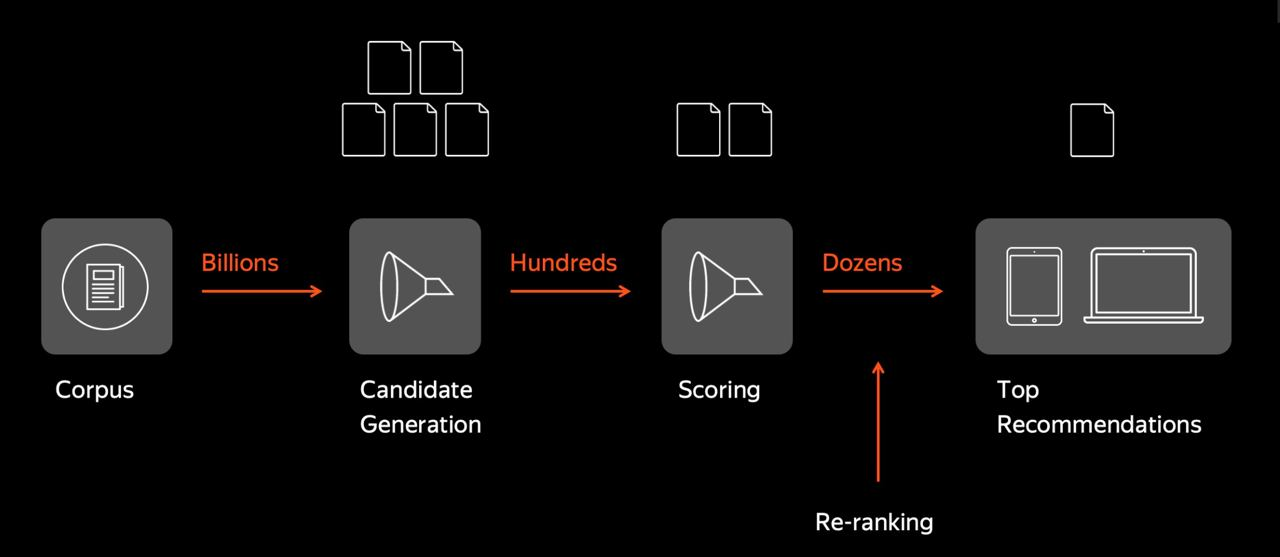

Приступим!

Все шаблоны ниже можно переписывать по своему усмотрению.

In [1]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs
import time

In [2]:
ratings = pd.read_csv('music_dataset.csv')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [3]:
tracks_info = pd.read_csv('tracks_info.csv')
tracks_info.head()

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

**Задание 1 (0.5 балл).** Реализуйте метрику $MAP@k$.

In [4]:
def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20):
    
    map_values = [] 
    for u in range(len(relevant)):

        if len(predicted[u]) > k:
            pred = predicted[u][:k]
        else:
            pred = predicted[u]
            
        is_relevant = np.isin(pred, relevant[u]) * 1 # бинарный массив, где 1 - означает релевантность
        precisions = np.cumsum(is_relevant) / (np.arange(len(is_relevant)) + 1)
        # считаем знаменатель по формуле 
        denominator = min(len(relevant[u]), k)
        
        precision_mean = precisions[is_relevant == 1].sum() / denominator
        map_values.append(precision_mean)
        
    return np.array(map_values).mean()

In [5]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
]

assert round(mapk(relevant, pred, k=5), 4) == 0.4331

Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [6]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [7]:
train_ratings, test_ratings = train_test_split(ratings)

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [8]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [9]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [10]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [11]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [12]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


Соберем все релевантные треки для каждого пользователя в список.

In [13]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

**Задание 2 (0.5 балла).** Реализуйте метод `get_test_recommendations` в классе `BaseModel`. Он принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забывайте удалять уже прослушанные треки из рекомендуемых.

In [14]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items), dtype = np.int32)
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.
        
    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []
        for user in range(self.n_users):
            test_preds.append(self.recommend(user))
            
        test_preds = self.remove_train_items(test_preds, k)

        return test_preds.tolist()

### Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать меру Жаккара:

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Во всех формулах 
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

**Задание 3.2 (0.5 балла).** Реализуйте функцию подсчета меры Жаккара.

Функция принимает матрицу оценок и вектор оценок пользователя $u$ и возвращает вектор со значениями похожести пользователя $u$ на всех пользователей. Старайтесь писать оптимизированный код, за неэффективную реализацию оценка может быть снижена.

Если я конечно правильно понял :) то все решается в одну строчку:

In [15]:
def jaccard(ratings: np.array, user_vector: np.array) -> np.array:
    
    return (ratings & user_vector).sum(axis = 1) / (ratings | user_vector).sum(axis = 1)

**Задание 4 (1 балл).** Реализуйте методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок. Значение парамметра `alpha` можно менять по своему усмотрению так, чтобы оно было разумным.

In [16]:
class User2User(BaseModel):
    def __init__(self, ratings):
        super().__init__(ratings)

        self.similarity_func = jaccard
        self.alpha = 0.01

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        return self.similarity_func(self.R, user_vector)
        

    def recommend(self, uid: int):
        user_ratings = self.R[uid]
        
        # чтобы не сравнивать с самим собой выкидываем из матрицы индекс юзера, считаем схожести
        sim_scores = self.similarity_func(np.delete(self.R, uid, axis = 0), 
                                          user_ratings)
        neighbors = np.where(sim_scores > self.alpha)[0]
        
        tracks_relevance = ((np.delete(self.R, uid, axis = 0)[neighbors].T @ sim_scores[neighbors]) / 
                            sim_scores[neighbors].sum())
        
        return tracks_relevance.argsort()[::-1]
        

**Задание 5 (0.5 балл).** Постройте график зависимости значений $MAP@k$ от разных $k$ при рекомендации на основе меры Жаккара, сравните его с рекомендициями самых популярных треков и случайных. Какой из трех способов рекомендаций оказался лучшим?

In [131]:
model_u2u = User2User(train_ratings)
pred_u2u = model_u2u.get_test_recommendations(k = 20)

/var/folders/80/wx2xrtm12cn4rjgnh957mx1m0000gn/T/ipykernel_276/1557439863.py:23: RuntimeWarning: invalid value encountered in true_divide
  tracks_relevance = ((np.delete(self.R, uid, axis = 0)[neighbors].T @ sim_scores[neighbors]) /


In [132]:
# для сравнения рекомендуем рандомные и наиболее популярные треки

class Most_Popular(BaseModel):
    def __init__(self, ratings):
        super().__init__(ratings)
        
    def recommend(self, uid: int):
        tracks_relevance = self.R.sum(axis = 0)
        return tracks_relevance.argsort()[::-1]
    
class Random_Rec(BaseModel):
    def __init__(self, ratings):
        super().__init__(ratings)
        
    def recommend(self, uid: int):
        return np.random.permutation(np.arange(self.n_items))
    
model_popular = Most_Popular(train_ratings)
pred_popular = model_popular.get_test_recommendations(k = 20)

model_random = Random_Rec(train_ratings)
pred_random = model_random.get_test_recommendations(k = 20)

''

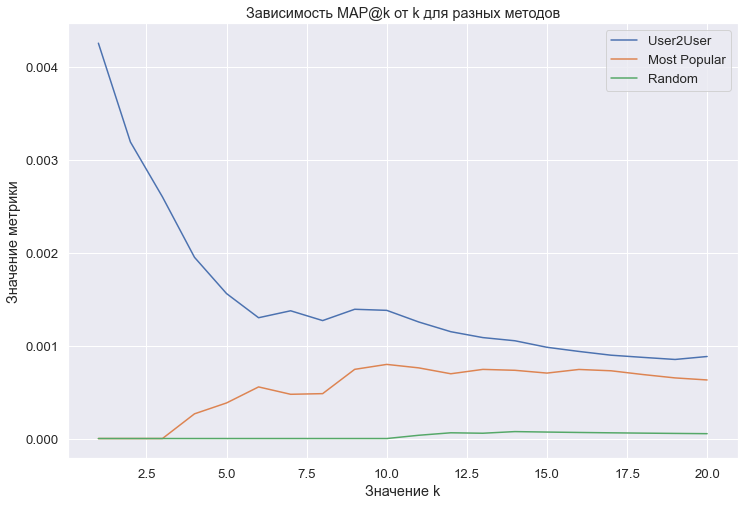

In [133]:
k_values = np.arange(20) + 1

maps_u2u = []
maps_popular = []
maps_random = []

for k in k_values:
    maps_u2u.append(mapk(test_relevant, pred_u2u, k = k))
    maps_popular.append(mapk(test_relevant, pred_popular, k = k))
    maps_random.append(mapk(test_relevant, pred_random, k = k))

sns.set(font_scale = 1.2)
plt.figure(figsize = (12, 8))
plt.title('Зависимость MAP@k от k для разных методов')
plt.xlabel('Значение k')
plt.ylabel('Значение метрики')

plt.plot(k_values, maps_u2u, label = 'User2User')
plt.plot(k_values, maps_popular, label = 'Most Popular')
plt.plot(k_values, maps_random, label = 'Random')
plt.legend()
;


In [136]:
max(maps_u2u) # лучшее значение метрики для U2U

0.00425531914893617

Как мы видим максимального качества достигает все же коллаборативная фильтрация, но при маленьких значениях k. Дальше значения метрики убывают с ростом k. 

Рекомендации популярных треков, наоборот, показывают рост метрики до определенного значения, а затем она остается примерно на одном уровне, но нигде не обгоняет U2U. 

Ну а рандомные рекомендации, очевидно, работают хуже всех, значения метрики околонулевые

В общем, если мы хотим порекомендовать пользователю небольшое число треков (а как мне кажется, в большинстве случаев это так), то User2User работает получше остальных методов. Хотя и в остальных случаях этот метод работает получше

**Бонус (1 балла).** Как вы могли заметить, матрица оценок получается очень разреженной, но мы работаем с ней как с обычной, это не дело. Перепишите код так, чтобы все методы могли работать с разреженными матрицами и сравните скорость работы такого подхода с оригинальным.

В общем я тут что-то пробовал, но в итоге после запуска у меня просто долго работает код, а потом умирает ядро аххааха) Так что я с позором иду дальше

In [24]:
# def jaccard_sparse(ratings, user_vector):
    
#     # тут получился конечно говнокод, на самом деле это просто аналог пересечений/объединений из numpy

#     intersec = np.array(ratings.multiply(user_vector).sum(axis = 1).ravel()[0])
#     union = np.array((ratings + scs.vstack([user_vector] * ratings.shape[0]) - 
#                       ratings.multiply(user_vector)).sum(axis = 1).ravel()[0])
    
#     return scs.csr_matrix(intersec / union)

# class BaseModelSparse():
#     def __init__(self, ratings: pd.DataFrame):
#         self.ratings = ratings
#         self.n_users = len(np.unique(self.ratings['userId']))
#         self.n_items = len(np.unique(self.ratings['trackId']))

#         #self.R = scs.csr_matrix((self.n_users, self.n_items), dtype = np.int32)
#         self.R = np.zeros((self.n_users, self.n_items), dtype = np.int32)
#         self.R[self.ratings['userId'], self.ratings['trackId']] = 1.
#         self.R = scs.csr_matrix(self.R)
        
#     def recommend(self, uid: int):
#         """
#         param uid: int - user's id
#         return: [n_items] - vector of recommended items sorted by their scores in descending order
#         """
#         raise NotImplementedError

#     def remove_train_items(self, preds: List[List[int]], k: int):
#         """
#         param preds: [n_users, n_items] - recommended items for each user
#         param k: int
#         return: np.array [n_users, k] - recommended items without training examples
#         """
#         new_preds = np.zeros((len(preds), k), dtype=int)
#         for user_id, user_data in self.ratings.groupby('userId'):
#             user_preds = preds[user_id]
#             new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

#         return new_preds

#     def get_test_recommendations(self, k: int):
#         test_preds = []
#         for user in range(self.n_users):
#             test_preds.append(self.recommend(user))
            
#         test_preds = self.remove_train_items(test_preds, k)

#         return test_preds.tolist()
        
# class User2UserSparse(BaseModelSparse):
#     def __init__(self, ratings):
#         super().__init__(ratings)

#         self.similarity_func = jaccard_sparse
#         self.alpha = 0.01
        
#     def recommend(self, uid: int):
#         user_ratings = self.R[uid]
        
#         # здесь уже не нашел аналог np.delete, поэтому делаю через индексы
#         idx_no_uid = np.delete(np.arange(self.n_users), uid)
        
#         sim_scores = self.similarity_func(self.R[idx_no_uid], user_ratings)
#         neighbors = np.where((sim_scores > self.alpha).toarray())[0]
        
#         tracks_relevance = ((self.R[idx_no_uid][neighbors].T @ sim_scores[neighbors]) / 
#                             sim_scores[neighbors].sum()).toarray()
        
#         return tracks_relevance.argsort()[::-1]


Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя. Хорошо ли у вас получилось?

In [199]:
user_id = np.random.randint(0, model_u2u.n_users)

In [200]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
37,The Way I Are,"['Timbaland', 'Keri Hilson', 'D.O.E.']"
106,Fergalicious,"['Fergie', 'will.i.am']"
177,Paper Planes,['M.I.A.']
198,I Like The Way,['Bodyrockers']
235,You Know I'm No Good,['Amy Winehouse']
236,Back To Black,['Amy Winehouse']
445,Fire Water Burn,['Bloodhound Gang']
464,Tainted Love,['Marilyn Manson']
472,This Is the New Shit,['Marilyn Manson']
480,Hollaback Girl,['Gwen Stefani']


In [201]:
preds = model_u2u.get_test_recommendations(15)

print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

/var/folders/80/wx2xrtm12cn4rjgnh957mx1m0000gn/T/ipykernel_276/1557439863.py:23: RuntimeWarning: invalid value encountered in true_divide
  tracks_relevance = ((np.delete(self.R, uid, axis = 0)[neighbors].T @ sim_scores[neighbors]) /


Predicted tracks:


,name,artists
24500,Way Down We Go,['KALEO']
805,Zombie,['The Cranberries']
7533,Highway to Hell,['AC/DC']
2555,Californication,['Red Hot Chili Peppers']
2481,Gangsta's Paradise,"['Coolio', 'L.V.']"
8263,Shape Of My Heart,['Sting']
11493,The Show Must Go On,['Queen']
35064,Thunder,['Imagine Dragons']
20094,Come And Get Your Love,['Redbone']
1019,It's My Life,['Bon Jovi']


In [202]:
test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]

print('Test-time tracks:')

tracks_info.loc[test_tracks][['name', 'artists']]

Test-time tracks:


,name,artists
64683,I WANNA BE YOUR SLAVE,['Måneskin']
64733,Pump the Brakes,['Dom Dolla']
64801,Follow You,['Imagine Dragons']
64802,Cutthroat,['Imagine Dragons']
64805,Somebody To Love,['Basstrologe']
65043,Nice To Meet Ya,"['Wes Nelson', 'Yxng Bane']"
65046,MONTERO (Call Me By Your Name),['Lil Nas X']
65114,The Magic Bomb,['Hoàng Read']
65371,Best Friend,"['Saweetie', 'Doja Cat', 'Chanmina', 'Jamie']"
65477,Hush,['The Marías']


Ну вообще, хоть рекомендации и не пробивают точные треки, но предсказывают что-то близкое. Например, совпадает автор Imagine Dragons, да и в целом встречаются похожие треки

### Часть 2. Модель со скрытыми переменными: ALS

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_u \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно. 

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

__P. S.__ Заметьте, что описанная модель предназначена для работы только с __явной__ информацией. В нашем случае от модели будет требоваться всегда возвращать 1, так как мы считаем ошибку только по парам, о которых получили фидбек. Поэтому логично подумать, что постановка задачи не имеет смысла. Однако, на практике оказывается, что из-за случайности в инициализации матриц $P$ и $Q$, обученные векторы для всех треков и пользователей в конце обучения получаются разными. Поэтому модель все же не лишена смысла.

__P. P. S.__ Для более разумной работы с неявной информацией был предложен метод iALS, его описание можно найти в лекции. Ниже будет бонус на его реализацию.

**Задание 6 (0.5 балла).** На лекции рассматривались два подхода к оптимизации параметров. Можно это делать обычным стохастческим градинтным спуском, а можно по очереди обновлять матрицы $P, Q$, и тогда получится метод Alternating Least Squares (ALS). Выведите формулы обновления параметров для обоих методов.

**SGD:**

$$
\nabla L_{p} = 2(\langle p_u, q_i \rangle - r_{ui})q_i + 2\lambda p_u 
$$

$$
\nabla L_{q} = 2(\langle p_u, q_i \rangle - r_{ui})p_u + 2\lambda q_i
$$

На константы вроде как можно забить, поэтому:

$$
p_u^{t+1} = p_u^{t} - \eta \left((\langle p_u^t, q_i^t \rangle - r_{ui})q_i^t + \lambda p_u^t\right)
$$

$$
q_i^{t+1} = q_i^{t} - \eta \left((\langle p_u^t, q_i^t \rangle - r_{ui})p_u^t + \lambda q_i^t \right)
$$

**ALS:**

Сначала найдем для $p_u$, дальше очевидно будет просто зеркально для $q_i$:

$$
\nabla L_{p} = \sum_{(u, i) \in R}2(q_i^T p_u - r_{ui})q_i + \sum_{u \in U}2\lambda p_u = 0
$$

$$
 \sum_{(u, i) \in R} q_i^T p_u q_i -  \sum_{(u, i) \in R} r_{ui} q_i + \sum_{u \in U}\lambda p_u = 0
$$

немного перепишем первое слагаемое

$$
 \sum_{(u, i) \in R} q_i q_i^T p_u  -  \sum_{(u, i) \in R} r_{ui} q_i + \sum_{u \in U}\lambda p_u = 0
$$

Для конкретного $u$ находим решение:
$$
p_u = (\sum_{(u, i) \in R} q_i q_i^T + \lambda I)^{-1} \sum_{(u, i) \in R}r_{ui} q_i 
$$

Тут уже суммирование не по всем парам, а только для конкретного $u$. Аналогично находим решение для $q_i$ (суммирование для конкретного i):

$$
q_i = (\sum_{(u, i) \in R} p_u p_u^T + \lambda I)^{-1} \sum_{(u, i) \in R}r_{ui} p_u 
$$

**Задание 7 (1.5 балла).** Реализуйте методы оптимизации параметров для обоих алгоритмов.

In [167]:
class LatentFactorModel(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd'):
        super().__init__(ratings)
        self.dim = dim
        
        assert mode in ['sgd', 'als']
        self.mode = mode

        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))

        self.lr = 0.0003
        self.lamb = 0.08

    def fit(self, num_iters=5):
        for epoch in tqdm(range(num_iters)):

            if self.mode == 'sgd':
                 
                # достаем пару (user, item) для которой известен рейтинг
                for pair in zip(self.ratings['userId'].values, self.ratings['trackId'].values):
                    # дальше по формулам тупо обновляем веса
                    self.P[pair[0]] -= self.lr * ((self.P[pair[0]] @ self.Q[pair[1]] - 
                    self.R[pair[0], pair[1]]) * self.Q[pair[1]] + self.lamb * self.P[pair[0]])
                    
                    self.Q[pair[1]] -= self.lr * ((self.P[pair[0]] @ self.Q[pair[1]] - 
                    self.R[pair[0], pair[1]]) * self.P[pair[0]] + self.lamb * self.Q[pair[1]])

            elif self.mode == 'als':
                
                # сначала фиксируем q, обновляем p
                for user in range(self.n_users):
                    mat = np.zeros(shape = (self.dim, self.dim)) # первый множитель
                    vec = np.zeros(self.dim)                     # второй множитель
                    
                    for item in self.ratings[self.ratings['userId'] == user]['trackId'].values:
                        mat += self.Q[item].reshape(-1, 1) @ self.Q[item].reshape(1, -1)
                        vec += self.R[user, item] * self.Q[item] 

                    self.P[user] = np.linalg.inv(mat + self.lamb * np.eye(self.dim)) @ vec
                    
                
                # теперь наоборот
                for item in range(self.n_items):
                    mat = np.zeros(shape = (self.dim, self.dim)) # первый множитель
                    vec = np.zeros(self.dim)                     # второй множитель
                    
                    for user in self.ratings[self.ratings['trackId'] == item]['userId'].values:
                        mat += self.P[user].reshape(-1, 1) @ self.P[user].reshape(1, -1)
                        vec += self.R[user, item] * self.P[user]
                        
                    self.Q[item] = np.linalg.inv(mat + self.lamb * np.eye(self.dim)) @ vec
                    
                

    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T

        return np.argsort(pred_rating)[::-1]

**Задание 8 (1 балл).** Для обоих алгоритмов подберите оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$. Как изменяется качество предсказаний с числом итераций обучения? Постройте соответствующие графики, сравните со случайным подхом и User2User, сделайте выводы. Какой алгоритм вам кажется более подходящим для данной задачи и почему?

__P. S.__ Хотя бы один из методов обучения должен приводить к лучшим результатам в сравнении с User2User подходом.

__P. P. S.__ Методу SGD свойственно переобучаться, поэтому при подборе параметров полезно смотреть на значения ошибки и оптимизируемой метрики на тренировочном датасете. Вы также можете менять начальную инициализацию и прочие параметры, за исключением архитектуры, на ваш вкус.

О неееет, мой ноут не выдержит такой нагрузки :(

In [168]:
# SGD
best_map_sgd = 0
k_sgd = None
best_dim_sgd = None
for dim in [100, 110, 128, 130, 140, 150, 160]:
    model_sgd = LatentFactorModel(train_ratings, dim = dim)
    model_sgd.fit()
    pred_sgd = model_sgd.get_test_recommendations(k = 20)
    

    for i in range(1, 21):
        map_ = mapk(test_relevant, pred_sgd, k = i)
        if map_ > best_map_sgd:
            
            best_map_sgd = map_
            k_sgd = i
            best_dim_sgd = dim

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [173]:
print(f'Лучшее качество для SGD: {best_map_sgd}')
print(f'Лучшее k для SGD: {k_sgd}')
print(f'Лучший dim для SGD: {best_dim_sgd}')

Лучшее качество для SGD: 0.00425531914893617
Лучшее k для SGD: 1
Лучший dim для SGD: 110


Уж простите, для ALS подбирать параметры я лучше не буду, иначе мой ноут взорвется. Запустим на дефолтных параметрах (уже можно будет увидеть качество лучше, и так понятно, что на подобранных параметрах метод также будет работать лучше других):

In [175]:
# ALS
model_als = LatentFactorModel(train_ratings, mode = 'als')
model_als.fit()
pred_als = model_als.get_test_recommendations(k = 20)

  0%|          | 0/5 [00:00<?, ?it/s]

In [176]:
maps_als = []
for i in range(1, 21):
    maps_als.append(mapk(test_relevant, pred_als, k = i))
    
print(max(maps_als)) # Лучшее качество для ALS

0.00851063829787234


Как мы видим, SGD показывает ровно такое же лучшее качество, как и U2U, причем в обоих случаях k = 1, то есть скорее всего просто совпадает доля правильных ответов. Еще один плюс SGD, что он работает довольно быстро (около 7 секунд). Да и в целом, если сделать подбор более грамотно (с лямбдой и lr), то по качеству он обойдет U2U, про случайный прогноз вообще молчу.

Что касается ALS, то он работает довольно долго, но это отчасти оправданно, так как есть прирост в качестве в два раза. В целом, если мы гонимся за качеством, то следует использовать ALS. Если же нам нужно быстро посортировать айтемы для дальнейшего ранжирования, то лучше брать SGD/U2U. По сравнению со случайными рекомендациями качество у ALS очевидно сильно больше

Если у вас получилось достаточно хорошее качество, то при оптимизации параметров марицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [178]:
example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = model_als.Q @ model_als.Q[example_trackId]
preds = preds / np.sqrt((model_als.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [179]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(model_als.Q[example_trackId])
similar_tracks

,name,artists,similarity
5512,Выхода нет,['Сплин'],1.000000
2058,Последний герой,['КИНО'],0.654579
2179,Восьмиклассница,['КИНО'],0.577297
5515,Романс,['Сплин'],0.516184
26075,Лошадка,['Найк Борзов'],0.512287
13264,Безобразная Эльза,['Крематорий'],0.504916
13263,Мусорный ветер,['Крематорий'],0.504916
16224,Пока горит свеча,['Машина времени'],0.504570
16637,Zodiac,['Zodiac'],0.502063
9689,Bicycle Race,['Queen'],0.502063


Вроде и правда довольно хорошо

**Бонус (1.5 балла).**

Постройте модель iALS и сравните ее качество с обучением ALS и SGD.

### Часть 3. Второй уровень рекомендаций.

Выше мы построили простейшие модели, которые показывают не слишком высокое качество, но зато работают очень быстро. Воспользуемся ими для того, чтобы отобрать некоторое количество наиболее перспективных треков, которые мы сможем отранжировать уже более сложной моделью (в нашем случае это будет [CatBoost](https://catboost.ai/en/docs/concepts/python-reference_catboost)).

**Задание 9 (1 балл).**

Для каждого пользователя возьмите топ-100 рекомендованных треков от модели LFM (ALS или SGD на ваш выбор) и топ-100 от модели User2User. Это будут наши кандидаты, которые мы затем будем ранжировать бустингом.

In [205]:
data_user = []

# сначала закидываем 100 рекомендаций ALS для каждого юзера
for u in range(len(test_relevant)):
    data_user.append(list(model_als.recommend(u)[:100]))
    
# добавляем U2U, которые не вошли в список (200 штук взял прям на крайняк)
data_u2u = model_u2u.get_test_recommendations(k = 200)
for i in range(len(data_user)):
    for rec in data_u2u[i]:
        if rec not in data_user[i]:
            data_user[i].append(rec)

# оставляем по 200 объектов
final_df = []
for el in data_user:
    final_df.append(el[:200])

/var/folders/80/wx2xrtm12cn4rjgnh957mx1m0000gn/T/ipykernel_276/1557439863.py:23: RuntimeWarning: invalid value encountered in true_divide
  tracks_relevance = ((np.delete(self.R, uid, axis = 0)[neighbors].T @ sim_scores[neighbors]) /


In [207]:
final_df[0][:5]

[63901, 53102, 5688, 24500, 20654]

Эх, к сожалению на этом моя домашка заканчивается, просто не успеваю сорянчик :(

<img src="https://media.tenor.com/D58R93FF5hYAAAAM/ronaldo-crying-cristiano-ronaldo.gif" style="width: 400px">

**Задание 10 (2 балла).**

Подготовьте датасет для обучения модели ранжирования. Он должен состоять из пар: объект, целевая переменная. Объект - это пара (user, item) и всякие дополнительные признаки на их основе. Предлагается создать набор следущих признаков, однако вы можете добавлять свои по желанию, если они вам кажутся разумными:
 1) id пользователя
 1) id трека
 1) косинусное расстояние между эмбеддингами LFM соответствующих пользователя и трека
 1) среднее значение меры Жаккара между этим пользователем и остальными из User2User модели
 1) доля пользователей, слушавших этот трек (взять из обучающей выборки в Части 1)
 1) количество прослушанных пользователем треков (взять из обучающей выборки в Части 1)

В качестве целевой переменной возьмем бинарную метку "попал ли трек в 50 последних прослушанных пользователем"

Разбейте полученную выборку на обучающую и тестовую в отношении 3:2 так, чтобы пропорции положительных и отрицательных примеров в обоих подвыборках были одинаковыми.

In [ ]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪

Как уже было сказано, для построения ранжирующей модели мы будем пользоваться библиотекой [CatBoost](https://www.youtube.com/watch?v=dQw4w9WgXcQ). 

Для преобразования датасета в удобный вид полезно использовать метод [`Pool`](https://catboost.ai/en/docs/concepts/python-reference_pool).

In [ ]:
import catboost

# group_id == user_id here
train_pool = catboost.Pool(X_train, y_train, group_id=train_group_id)
test_pool = catboost.Pool(X_test, y_test, group_id=test_group_id)

**Задание 11 (1 балл)**

Обучите `CatBoostClassifier`. С его помощью сделайте предсказания для тестовой выборки и посчитайте MAP@20. Сравните с рекомендациями моделей User2User и LFM. Учтите, что для честного сравнения необходимо пересчитать предсказания моделей на нашей новой тестовой выборке. Получилось ли улучшить результаты?

In [ ]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪

**Задание 12 (1 балл)**

Обучите `CatBoostRanker`, выбрав подходящую функцию ранжирования из тех, которые были рассмотрены на лекции. Проделайте все те же действия, что и с `CatBoostClassifier` и сравните результаты.

In [ ]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪